In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
print("Loading full season Statcast data...")
print("This may take a few minutes...")

# Get full 2024 season (adjust dates as needed)
start_date = "2024-04-01"
end_date = "2024-09-30"

# Load the data
df_season = statcast(start_dt=start_date, end_dt=end_date)

print(f"Loaded {len(df_season):,} total rows")
print(f"Date range: {df_season['game_date'].min()} to {df_season['game_date'].max()}")
print(f"Dataframe shape: {df_season.shape}")

# Check what columns we have for identifying batters vs pitchers
print(f"\nKey columns available:")
batter_cols = [col for col in df_season.columns if 'batter' in col.lower()]
pitcher_cols = [col for col in df_season.columns if 'pitcher' in col.lower()]
print(f"Batter columns: {batter_cols}")
print(f"Pitcher columns: {pitcher_cols}")

Loading full season Statcast data...
This may take a few minutes...
This is a large query, it may take a moment to complete


100%|█████████████████████████████████████████████████████████| 183/183 [00:03<00:00, 51.43it/s]


Loaded 692,943 total rows
Date range: 2024-04-01 00:00:00 to 2024-09-30 00:00:00
Dataframe shape: (692943, 118)

Key columns available:
Batter columns: ['batter', 'batter_days_since_prev_game', 'batter_days_until_next_game', 'api_break_x_batter_in', 'intercept_ball_minus_batter_pos_x_inches', 'intercept_ball_minus_batter_pos_y_inches']
Pitcher columns: ['pitcher', 'delta_pitcher_run_exp', 'n_thruorder_pitcher', 'pitcher_days_since_prev_game', 'pitcher_days_until_next_game']


In [5]:
print("Filtering to BATTERS ONLY and cleaning data...")

# First, let's examine the data structure
print(f"Sample of key columns:")
sample_cols = ['player_name', 'events', 'launch_speed', 'launch_angle']
if 'batter' in df_season.columns:
    sample_cols.append('batter')
if 'pitcher' in df_season.columns:
    sample_cols.append('pitcher')

print(df_season[sample_cols].head())

# CRITICAL: Filter to batting perspective only
# The data should have either separate batter/pitcher IDs or some indicator
# Let's check if we need to filter by a specific column

if 'batter' in df_season.columns and 'pitcher' in df_season.columns:
    print("\nFound separate batter and pitcher columns")
    # Keep all rows - each row represents one plate appearance from batter's perspective
    df_batting = df_season.copy()
    print(f"Using batter column for player identification")
    # Use batter ID as the player identifier
    df_batting['player_name'] = df_batting['batter'].astype(str)
    
elif 'player_name' in df_season.columns:
    print("\nUsing player_name column - need to verify this is batter data")
    df_batting = df_season.copy()
    
else:
    print("\nNeed to identify how to separate batters from pitchers")
    print(f"All columns: {list(df_season.columns)}")

# Filter to only include batted balls and walks/HBP (things that contribute to wOBA)
woba_events = [
    'single', 'double', 'triple', 'home_run',
    'walk', 'hit_by_pitch', 'intent_walk',
    'field_out', 'strikeout', 'force_out', 'fielders_choice_out',
    'grounded_into_double_play', 'pop_out', 'fly_out', 'lineout'
]

# Filter to relevant events
df_filtered = df_batting[df_batting['events'].isin(woba_events)].copy()

# Remove rows with missing critical data for batted balls
batted_ball_events = [
    'single', 'double', 'triple', 'home_run',
    'field_out', 'force_out', 'fielders_choice_out',
    'grounded_into_double_play', 'pop_out', 'fly_out', 'lineout'
]

# For batted balls, need launch speed and angle
batted_balls_mask = df_filtered['events'].isin(batted_ball_events)
df_filtered = df_filtered[
    ~batted_balls_mask | 
    (batted_balls_mask & df_filtered['launch_speed'].notna() & df_filtered['launch_angle'].notna())
].copy()

print(f"\nAfter filtering to batting events: {len(df_filtered):,} plate appearances")
print(f"Unique batters: {df_filtered['player_name'].nunique():,}")
print(f"Events distribution:")
print(df_filtered['events'].value_counts())

Filtering to BATTERS ONLY and cleaning data...
Sample of key columns:
     player_name     events  launch_speed  launch_angle  batter  pitcher
200  Díaz, Edwin  field_out          87.6           -30  518595   621242
203  Díaz, Edwin       None          <NA>          <NA>  518595   621242
211  Díaz, Edwin       None          <NA>          <NA>  518595   621242
213  Díaz, Edwin       None          <NA>          <NA>  518595   621242
221  Díaz, Edwin       None          <NA>          <NA>  518595   621242

Found separate batter and pitcher columns
Using batter column for player identification

After filtering to batting events: 173,615 plate appearances
Unique batters: 651
Events distribution:
events
field_out                    71959
strikeout                    40070
single                       25204
walk                         14013
double                        7600
home_run                      5325
force_out                     3374
grounded_into_double_play     3128
hit_by_pitch 

In [6]:
print("Setting up target variable (wOBA values)...")

# Check if woba_value exists, if not calculate it
if 'woba_value' in df_filtered.columns:
    df_filtered['woba_value_actual'] = df_filtered['woba_value'].fillna(0)
    print("Using existing woba_value column")
else:
    print("woba_value column not found, calculating manually...")
    def calculate_woba_value(events):
        woba_weights = {
            'walk': 0.690, 'hit_by_pitch': 0.719, 'intent_walk': 0.690,
            'single': 0.888, 'double': 1.271, 'triple': 1.616, 'home_run': 2.101,
            'field_out': 0.0, 'strikeout': 0.0, 'force_out': 0.0,
            'fielders_choice_out': 0.0, 'grounded_into_double_play': 0.0,
            'pop_out': 0.0, 'fly_out': 0.0, 'lineout': 0.0
        }
        return events.map(woba_weights)
    df_filtered['woba_value_actual'] = calculate_woba_value(df_filtered['events'])

print("Target variable ready:")
print(f"Mean wOBA value: {df_filtered['woba_value_actual'].mean():.3f}")
print(f"Non-zero wOBA values: {(df_filtered['woba_value_actual'] > 0).sum():,}")


Setting up target variable (wOBA values)...
Using existing woba_value column
Target variable ready:
Mean wOBA value: 0.318
Non-zero wOBA values: 54,831


In [7]:
def create_model_features(df):
    """Create features for xwOBA prediction model"""
    df = df.copy()
    
    # Fill missing values
    df['launch_speed'] = df['launch_speed'].fillna(0)
    df['launch_angle'] = df['launch_angle'].fillna(0) 
    
    # For walks/HBP, we don't have batted ball data, so set to special values
    walk_events = ['walk', 'hit_by_pitch', 'intent_walk']
    walk_mask = df['events'].isin(walk_events)
    
    # Set launch speed/angle to special values for walks (model will learn this pattern)
    df.loc[walk_mask, 'launch_speed'] = -1
    df.loc[walk_mask, 'launch_angle'] = -999
    
    # Additional features
    df['launch_speed_squared'] = df['launch_speed'] ** 2
    df['abs_launch_angle'] = np.abs(df['launch_angle'])
    df['speed_angle_interaction'] = df['launch_speed'] * np.abs(df['launch_angle'])
    
    # Distance from optimal launch angle (around 25-30 degrees for home runs)
    df['optimal_angle_distance'] = np.abs(df['launch_angle'] - 27)
    
    # Is walk indicator
    df['is_walk'] = walk_mask.astype(int)
    
    return df

# Apply feature engineering
df_model = create_model_features(df_filtered)

print("Features created successfully!")
print(f"Total batting observations: {len(df_model):,}")
print(f"Walks/HBP: {df_model['is_walk'].sum():,}")
print(f"Batted balls: {(df_model['is_walk'] == 0).sum():,}")


Features created successfully!
Total batting observations: 173,615
Walks/HBP: 15,976
Batted balls: 157,639


In [8]:
# Define features for the model
feature_columns = [
    'launch_speed',
    'launch_angle', 
    'launch_speed_squared',
    'abs_launch_angle',
    'speed_angle_interaction',
    'optimal_angle_distance',
    'is_walk'
]

# Prepare training data
X = df_model[feature_columns].fillna(0)
y = df_model['woba_value_actual']

print("Model features for BATTER xwOBA prediction:")
for i, col in enumerate(feature_columns):
    print(f"{i+1}. {col}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {len(X_train):,} batting plate appearances")
print(f"Test set: {len(X_test):,} batting plate appearances")

# Train the model
print("\nTraining Random Forest model for batter xwOBA...")
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("Batter xwOBA model training completed!")

Model features for BATTER xwOBA prediction:
1. launch_speed
2. launch_angle
3. launch_speed_squared
4. abs_launch_angle
5. speed_angle_interaction
6. optimal_angle_distance
7. is_walk

Training set: 138,892 batting plate appearances
Test set: 34,723 batting plate appearances

Training Random Forest model for batter xwOBA...
Batter xwOBA model training completed!


In [9]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("Batter xwOBA Model Performance on Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance for Batter xwOBA:")
print(feature_importance)

Batter xwOBA Model Performance on Test Set:
R² Score: 0.5300
RMSE: 0.3506
MSE: 0.1229

Feature Importance for Batter xwOBA:
                   feature  importance
5   optimal_angle_distance    0.291076
2     launch_speed_squared    0.192192
0             launch_speed    0.186202
4  speed_angle_interaction    0.160105
6                  is_walk    0.141627
1             launch_angle    0.020129
3         abs_launch_angle    0.008670


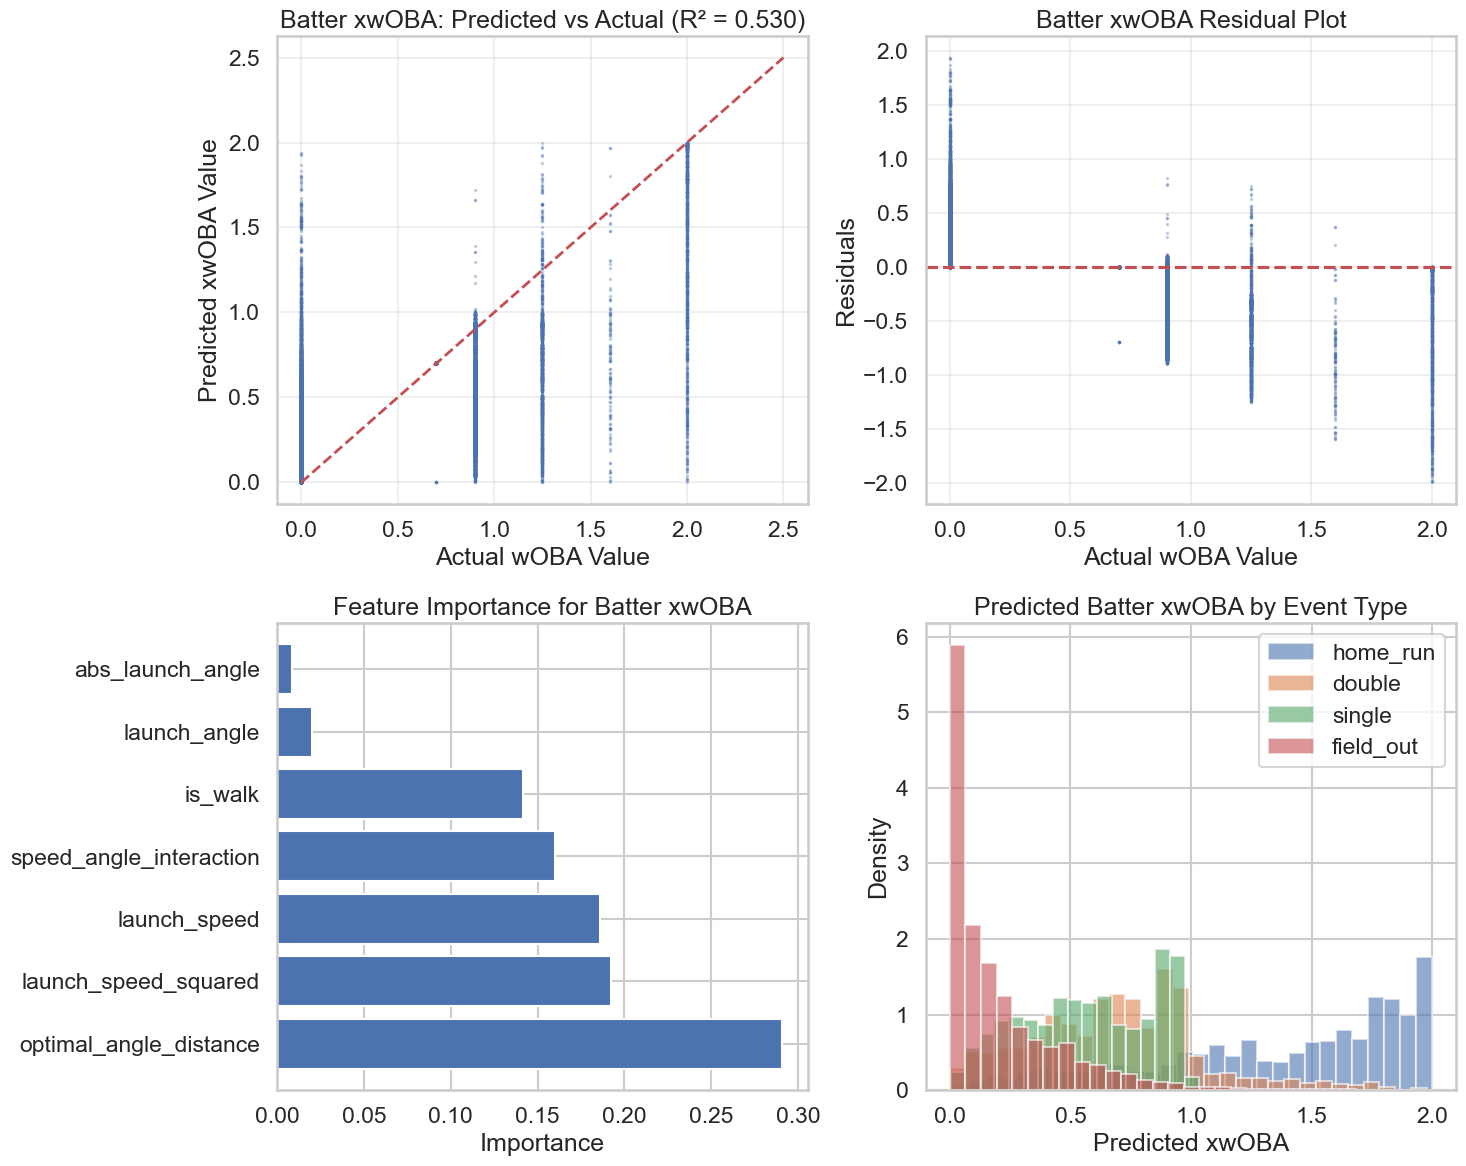

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicted vs Actual
axes[0,0].scatter(y_test, y_pred, alpha=0.3, s=1)
axes[0,0].plot([0, 2.5], [0, 2.5], 'r--', linewidth=2)
axes[0,0].set_xlabel('Actual wOBA Value')
axes[0,0].set_ylabel('Predicted xwOBA Value') 
axes[0,0].set_title(f'Batter xwOBA: Predicted vs Actual (R² = {r2:.3f})')
axes[0,0].grid(True, alpha=0.3)

# 2. Residuals
residuals = y_pred - y_test
axes[0,1].scatter(y_test, residuals, alpha=0.3, s=1)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Actual wOBA Value')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Batter xwOBA Residual Plot')
axes[0,1].grid(True, alpha=0.3)

# 3. Feature importance
axes[1,0].barh(feature_importance['feature'], feature_importance['importance'])
axes[1,0].set_xlabel('Importance')
axes[1,0].set_title('Feature Importance for Batter xwOBA')

# 4. Distribution of predictions by event type
sample_data = df_model.sample(50000) if len(df_model) > 50000 else df_model
for event in ['home_run', 'double', 'single', 'field_out']:
    if event in sample_data['events'].values:
        event_data = sample_data[sample_data['events'] == event]
        if len(event_data) > 10:
            axes[1,1].hist(rf_model.predict(event_data[feature_columns]), 
                          alpha=0.6, label=event, bins=30, density=True)

axes[1,1].set_xlabel('Predicted xwOBA')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Predicted Batter xwOBA by Event Type')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [11]:
print("Preparing BATTER-level validation...")

# Add predictions to the full model dataset
df_model['xwoba_predicted'] = rf_model.predict(X)

# Filter to BATTERS with sufficient plate appearances
min_pa = 200  # Minimum plate appearances for a batter

batter_stats = df_model.groupby('player_name').agg({
    'woba_value_actual': ['mean', 'count'],
    'xwoba_predicted': 'mean'
}).round(4)

# Flatten column names
batter_stats.columns = ['actual_woba', 'plate_appearances', 'predicted_xwoba']
batter_stats = batter_stats.reset_index()

# Filter to qualified batters
qualified_batters = batter_stats[
    batter_stats['plate_appearances'] >= min_pa
].copy()

print(f"Batters with {min_pa}+ PA: {len(qualified_batters)}")
print(f"Total plate appearances covered: {qualified_batters['plate_appearances'].sum():,}")

# Show sample of batters to verify we have actual hitters
print(f"\nSample of batters in dataset:")
sample_batters = qualified_batters.sample(min(10, len(qualified_batters)))
print(sample_batters[['player_name', 'actual_woba', 'predicted_xwoba', 'plate_appearances']])

Preparing BATTER-level validation...
Batters with 200+ PA: 362
Total plate appearances covered: 152,924

Sample of batters in dataset:
    player_name  actual_woba  predicted_xwoba  plate_appearances
542      681351       0.3138           0.3340                503
130      621020       0.3105           0.3188                570
487      676609       0.2831           0.2666                452
175      641598       0.2855           0.2917                420
158      624428       0.2639           0.2928                280
219      650489        0.328           0.3244                605
345      666158       0.3247           0.3219                457
406      669304       0.3362           0.3178                420
550      681807         0.35           0.3275                367
235      656582       0.3101           0.2835                383


In [12]:
# Calculate correlation
correlation = qualified_batters['actual_woba'].corr(qualified_batters['predicted_xwoba'])
batter_mse = mean_squared_error(qualified_batters['actual_woba'], qualified_batters['predicted_xwoba'])
batter_rmse = np.sqrt(batter_mse)

print("BATTER-Level Validation Results:")
print(f"Correlation: {correlation:.4f}")
print(f"RMSE: {batter_rmse:.4f}")
print(f"MSE: {batter_mse:.4f}")

# Show top and bottom batters
print(f"\nTop 10 Predicted xwOBA Batters (min {min_pa} PA):")
top_batters = qualified_batters.nlargest(10, 'predicted_xwoba')
print(top_batters[['player_name', 'actual_woba', 'predicted_xwoba', 'plate_appearances']])

print(f"\nBottom 10 Predicted xwOBA Batters (min {min_pa} PA):")
bottom_batters = qualified_batters.nsmallest(10, 'predicted_xwoba')
print(bottom_batters[['player_name', 'actual_woba', 'predicted_xwoba', 'plate_appearances']])

# Biggest prediction errors
qualified_batters['abs_error'] = abs(qualified_batters['predicted_xwoba'] - qualified_batters['actual_woba'])
print(f"\nLargest Prediction Errors:")
error_batters = qualified_batters.nlargest(10, 'abs_error')
print(error_batters[['player_name', 'actual_woba', 'predicted_xwoba', 'abs_error', 'plate_appearances']])

BATTER-Level Validation Results:
Correlation: 0.8589
RMSE: 0.0198
MSE: 0.0004

Top 10 Predicted xwOBA Batters (min 200 PA):
    player_name  actual_woba  predicted_xwoba  plate_appearances
71       592450       0.4915           0.4893                653
323      665742       0.4257           0.4696                677
254      660271       0.4428           0.4443                680
433      670541       0.4146           0.4243                591
320      665489       0.4035           0.4124                658
26       542303       0.4017           0.4101                665
281      663656       0.4289           0.4077                311
507      677951       0.4138           0.4000                672
110      606466       0.4047           0.3983                542
121      608369       0.3679           0.3980                506

Bottom 10 Predicted xwOBA Batters (min 200 PA):
    player_name  actual_woba  predicted_xwoba  plate_appearances
83       595281       0.2514           0.2333  

In [16]:
# =====================================================================
# Cell 10.5: Diagnose pitcher vs batter issue
# =====================================================================
print("DIAGNOSING PITCHER vs BATTER DATA:")

# Check what columns we actually have for player identification
print(f"\nColumns containing 'player': {[col for col in df_model.columns if 'player' in col.lower()]}")
print(f"Columns containing 'batter': {[col for col in df_model.columns if 'batter' in col.lower()]}")
print(f"Columns containing 'pitcher': {[col for col in df_model.columns if 'pitcher' in col.lower()]}")

# Look at the actual data structure
print(f"\nSample of key identification columns:")
id_cols = ['player_name']
if 'batter' in df_model.columns:
    id_cols.append('batter')
if 'pitcher' in df_model.columns:
    id_cols.append('pitcher')

sample_data = df_model[id_cols + ['events', 'launch_speed']].head(10)
print(sample_data)

# Check if we have both batter and pitcher IDs for the same row
if 'batter' in df_model.columns and 'pitcher' in df_model.columns:
    print(f"\nChecking if batter != pitcher (should always be True):")
    same_player = (df_model['batter'] == df_model['pitcher']).sum()
    print(f"Rows where batter == pitcher: {same_player} (should be 0)")
    
    print(f"\nUnique batters: {df_model['batter'].nunique()}")
    print(f"Unique pitchers: {df_model['pitcher'].nunique()}")
    
    # Show some actual player names if we can map IDs to names
    print(f"\nPlayer ID to name mapping check:")
    print(f"Using player_name as: {df_model['player_name'].dtype}")
    
# Let's see if player_name is actually batter names or something else
print(f"\nTop wOBA performers by current 'player_name':")
top_woba = qualified_batters.nlargest(5, 'actual_woba')
print(top_woba[['player_name', 'actual_woba', 'predicted_xwoba']])

# Check if these look like pitcher or batter statistics
print(f"\nwOBA distribution (should be batter-like, not pitcher-like):")
print(f"Mean wOBA: {qualified_batters['actual_woba'].mean():.3f}")
print(f"Min wOBA: {qualified_batters['actual_woba'].min():.3f}")
print(f"Max wOBA: {qualified_batters['actual_woba'].max():.3f}")
print(f"Players with wOBA > 0.400: {(qualified_batters['actual_woba'] > 0.400).sum()}")
print(f"Players with wOBA < 0.250: {(qualified_batters['actual_woba'] < 0.250).sum()}")

DIAGNOSING PITCHER vs BATTER DATA:

Columns containing 'player': ['player_name', 'n_priorpa_thisgame_player_at_bat']
Columns containing 'batter': ['batter', 'batter_days_since_prev_game', 'batter_days_until_next_game', 'api_break_x_batter_in', 'intercept_ball_minus_batter_pos_x_inches', 'intercept_ball_minus_batter_pos_y_inches']
Columns containing 'pitcher': ['pitcher', 'delta_pitcher_run_exp', 'n_thruorder_pitcher', 'pitcher_days_since_prev_game', 'pitcher_days_until_next_game']

Sample of key identification columns:
    player_name  batter  pitcher     events  launch_speed
200      518595  518595   621242  field_out          87.6
225      657656  657656   621242  strikeout           0.0
257      642201  642201   621242     single          72.0
297      621566  621566   621242  field_out          76.1
305      657193  657193   572955  strikeout           0.0
400      578428  578428   572955  field_out          86.7
462      596019  596019   572955   home_run         107.2
481      51

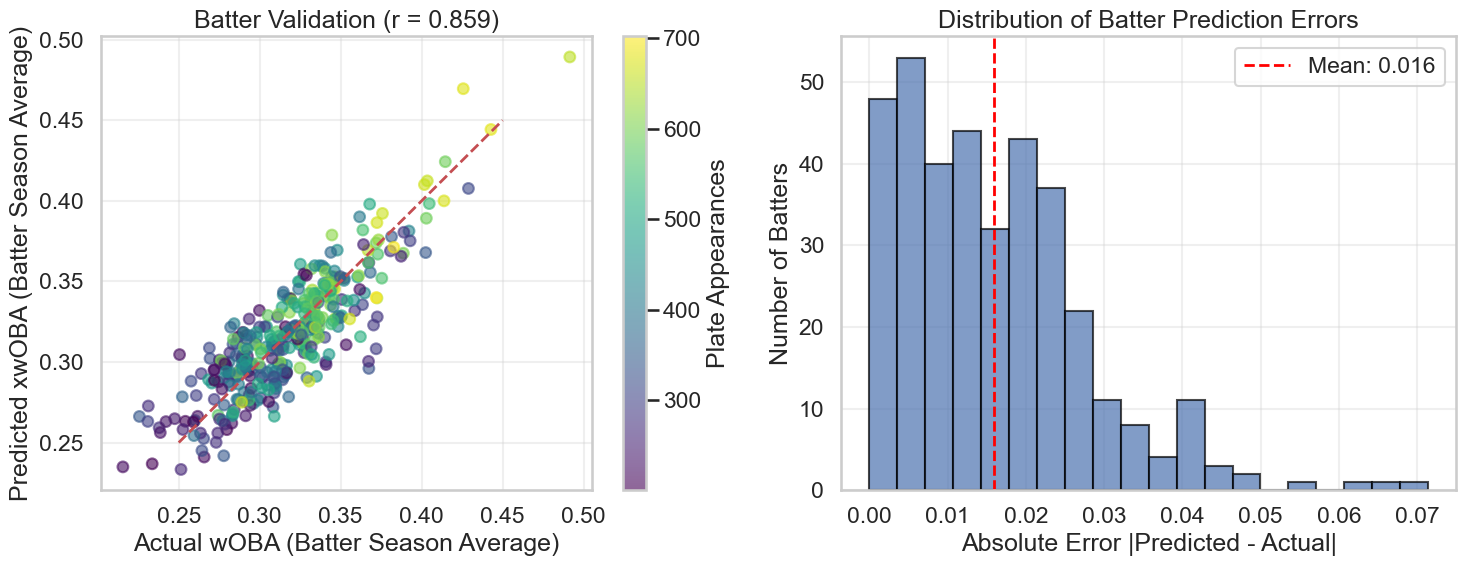

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Batter correlation plot
scatter = axes[0].scatter(qualified_batters['actual_woba'], 
                         qualified_batters['predicted_xwoba'], 
                         s=60, alpha=0.6, 
                         c=qualified_batters['plate_appearances'], 
                         cmap='viridis')
axes[0].plot([0.25, 0.45], [0.25, 0.45], 'r--', linewidth=2)
axes[0].set_xlabel('Actual wOBA (Batter Season Average)')
axes[0].set_ylabel('Predicted xwOBA (Batter Season Average)')
axes[0].set_title(f'Batter Validation (r = {correlation:.3f})')
axes[0].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Plate Appearances')

# Error distribution
axes[1].hist(qualified_batters['abs_error'], bins=20, alpha=0.7, edgecolor='black')
axes[1].axvline(qualified_batters['abs_error'].mean(), color='red', 
               linestyle='--', linewidth=2, label=f'Mean: {qualified_batters["abs_error"].mean():.3f}')
axes[1].set_xlabel('Absolute Error |Predicted - Actual|')
axes[1].set_ylabel('Number of Batters')
axes[1].set_title('Distribution of Batter Prediction Errors')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
print("Final Batter xwOBA Model Analysis:")
print(f"Individual plate appearance R²: {r2:.4f}")
print(f"Batter-level correlation: {correlation:.4f}")

# Analyze by launch speed ranges for batters
print("\nBatter model performance by launch speed ranges:")
speed_ranges = [(0, 70), (70, 85), (85, 95), (95, 105), (105, 120)]

for low, high in speed_ranges:
    mask = (df_model['launch_speed'] >= low) & (df_model['launch_speed'] < high)
    subset = df_model[mask]
    if len(subset) > 100:  # Only show ranges with sufficient data
        corr = subset['woba_value_actual'].corr(subset['xwoba_predicted'])
        rmse = np.sqrt(mean_squared_error(subset['woba_value_actual'], subset['xwoba_predicted']))
        print(f"Exit Velo {low}-{high} mph: n={len(subset):,}, r={corr:.3f}, RMSE={rmse:.3f}")

# Show some example batter predictions
print("\nExample batter xwOBA predictions for different scenarios:")
example_scenarios = [
    {"launch_speed": 110, "launch_angle": 25, "description": "Hard hit, optimal angle"},
    {"launch_speed": 95, "launch_angle": 15, "description": "Medium hit, line drive"},
    {"launch_speed": 75, "launch_angle": 45, "description": "Weak pop-up"},
    {"launch_speed": -1, "launch_angle": -999, "description": "Walk"}
]

for scenario in example_scenarios:
    # Create feature vector
    features = pd.DataFrame([{
        'launch_speed': scenario['launch_speed'],
        'launch_angle': scenario['launch_angle'],
        'launch_speed_squared': scenario['launch_speed'] ** 2,
        'abs_launch_angle': abs(scenario['launch_angle']),
        'speed_angle_interaction': scenario['launch_speed'] * abs(scenario['launch_angle']),
        'optimal_angle_distance': abs(scenario['launch_angle'] - 27),
        'is_walk': 1 if scenario['launch_speed'] == -1 else 0
    }])
    
    prediction = rf_model.predict(features)[0]
    print(f"{scenario['description']}: xwOBA = {prediction:.3f}")

print(f"\nBatter xwOBA Model Complete!")
print(f"Your model achieves a {correlation:.3f} correlation with actual batter wOBA at the season level!")
print(f"Model trained on {len(df_model):,} batting plate appearances from {df_model['player_name'].nunique():,} unique batters")

Final Batter xwOBA Model Analysis:
Individual plate appearance R²: 0.5300
Batter-level correlation: 0.8589

Batter model performance by launch speed ranges:
Exit Velo 0-70 mph: n=53,099, r=0.651, RMSE=0.160
Exit Velo 70-85 mph: n=27,425, r=0.686, RMSE=0.289
Exit Velo 85-95 mph: n=31,035, r=0.610, RMSE=0.336
Exit Velo 95-105 mph: n=35,368, r=0.542, RMSE=0.551
Exit Velo 105-120 mph: n=10,706, r=0.746, RMSE=0.491

Example batter xwOBA predictions for different scenarios:
Hard hit, optimal angle: xwOBA = 1.947
Medium hit, line drive: xwOBA = 0.755
Weak pop-up: xwOBA = 0.146
Walk: xwOBA = 0.700

Batter xwOBA Model Complete!
Your model achieves a 0.859 correlation with actual batter wOBA at the season level!
Model trained on 173,615 batting plate appearances from 651 unique batters
